In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import itertools
import math
import os

<h1>Load Data</h1>

In [32]:
# Load data from files
df = pd.DataFrame()
path = 'data/'
for file in os.listdir(path):     # Concatinates all the csv's in the path folder and gives them labels based on year
    if file.lower().endswith(".csv"):
        file_name = path+"/"+file
        data = pd.read_csv(file_name) 
        data['Year'] = file[:file.index('.')]
        df = pd.concat([df, data]) # classified based on folder path

        
df = df[["SYSTEM", "DATE", "TIME", "SEVERITY", "ROAD_DESC", "VEHICLES", "CONTOUR", "CONDITION", "LIGHTING", "WEATHER", "CITY", "COUNTY", "LATITUDE", "LONGITUDE", "AGE_1", "AGE_2"]]
df

,SYSTEM,DATE,TIME,SEVERITY,ROAD_DESC,VEHICLES,CONTOUR,CONDITION,LIGHTING,WEATHER,CITY,COUNTY,LATITUDE,LONGITUDE,AGE_1,AGE_2
0,CITY STREET,1/1/2008,0.0,PDO,AT INTERSECTION,1,UNKNOWN,UNKNOWN,UNKNOWN,NONE,FAIRPLAY,PARK,0.000000,0.000000,50,0
1,CITY STREET,1/1/2008,12.0,PDO,UNKNOWN,1,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,PUEBLO,PUEBLO,0.000000,0.000000,0,0
2,CITY STREET,1/1/2008,13.0,INJ,INTERSECTION RELATED,2,STRAIGHT ON-LEVEL,WET W/VIS ICY ROAD TREATMENT,DARK-LIGHTED,UNKNOWN,DENVER,DENVER,39.738436,-104.982325,59,42
3,CITY STREET,1/1/2008,29.0,PDO,NON-INTERSECTION,1,CURVE ON-GRADE,DRY,DARK-UNLIGHTED,UNKNOWN,DURANGO,LA PLATA,0.000000,0.000000,18,0
4,CITY STREET,1/1/2008,30.0,PDO,NON-INTERSECTION,2,STRAIGHT ON-LEVEL,SNOWY,DARK-LIGHTED,UNKNOWN,LAKEWOOD,JEFFERSON,39.672860,-105.147678,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112186,STATE HIGHWAY,12/31/2007,2342.0,INJ,AT INTERSECTION,2,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,NONE,PUEBLO,PUEBLO,38.219990,-104.643721,22,23
112187,CITY STREET,12/31/2007,2343.0,PDO,INTERSECTION RELATED,2,STRAIGHT ON-LEVEL,DRY,DARK-LIGHTED,NONE,DENVER,DENVER,39.733690,-105.000150,19,26
112188,INTERSTATE,12/31/2007,2343.0,PDO,NON-INTERSECTION,1,STRAIGHT ON-LEVEL,SNOWY,DARK-UNLIGHTED,NONE,VAIL,EAGLE,39.634044,-106.411499,34,0
112189,COUNTY ROAD,12/31/2007,2350.0,PDO,INTERSECTION RELATED,1,STRAIGHT ON-GRADE,ICY,DARK-LIGHTED,NONE,NaN,DOUGLAS,39.559040,-104.896640,18,0


<h1>Pre Processing</h1>

In [34]:
# Pass in the data frame and an array of the column names you want to convert
def create_labels(temp, columns):
    for i in columns:
        labels = LabelEncoder().fit_transform(temp[i])
        temp[i] = labels
    return temp

In [4]:
# Returns a data frame use .squeeze() to turn into a Series
# .name can only be used on a Series
def pre_processing(data, name):
    # remove all 0, null, and UNKONW rows
    if not isinstance(data, pd.core.frame.DataFrame):
        data = data.to_frame()
    
#     print(data[data[name] == "UNKNOWN"])
    
    if (data[name].dtypes == object):
        data = data[data[name] != "UNKNOWN"]
    else:
        data = data[data[name] != 0]
        
    data = data.dropna()
    return data

In [5]:
# Returns a dataframe that contains the 2 entered names. It removes a row if one of the columns contains
# 0, null, or UNKNOWN
def pre_processing2(data1, name1,  data2, name2):
    data = data1.to_frame()
    data[name2] = data2
    
    if (data[name1].dtypes == object) or (data[name2].dtypes == object):
        data = data[(data[[name1,name2]] != "UNKNOWN").all(axis=1)]
    else:
        data = data[(data[[name1,name2]] != 0).all(axis=1)]
        
    data = data.dropna()
    
    return data

<h1>Function Definitions</h1>

In [6]:
def heat_map(arr, min=0):
    # plot correlation matrix
    max = arr.max(axis=1).max()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    subplotsize=[8.,8.]
    figuresize=[10.,10.]   
    left = 0.5*(1.-subplotsize[0]/figuresize[0])
    right = 1.-left
    bottom = 0.5*(1.-subplotsize[1]/figuresize[1])
    top = 1.-bottom
    fig.subplots_adjust(left=left,right=right,bottom=bottom,top=top)
    cax = ax.matshow(arr, vmin=min, vmax=max)
    fig.colorbar(cax)
    xticks = np.arange(0,len(arr.columns),1)
    yticks = np.arange(0,len(arr.index),1)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(arr.columns, rotation=90)
    ax.set_yticklabels(arr.index)
    plt.show()

In [7]:
# This function will get the nominal data points and count of a given column. Must be entered with quotations
def get_count(column):
    
    dict = {}
    for i in column:
        if not i in dict:
            dict[i] = 0

    for i in column:
        dict[i] = dict[i] + 1
    count = pd.DataFrame(columns=(column.name, "COUNT"))   

    for i in dict:
        data = {column.name:[i], "COUNT": [dict[i]]}
        temp = pd.DataFrame(data)
        count = pd.concat([count, temp])
    return count

In [11]:
#This function assumes d = 1, and tells if there is a correlation or not according to the critical values of the Chi Squared Distribution

def check_correlation(value, prob):
    if prob == .05:
        if value > 3.841:
            return "correlated"
        else:
            return "not correlated"
    elif prob == .01:
        if value > 6.635:
            return "correlated"
        else:
            return "not correlated"
    elif prob == .001:
        if value > 10.828:
            return "correlated"
        else:
            return "not correlated"
    else:
        print("Enter a probability of .05, .01, or .001")
        return

In [9]:
# This is how we can access individual elements of the data frame
# for j in range(count_a.shape[0]):
#     print(count_a[col_a][j], count_a["COUNT"][j])

#This function will take 2 columns with nominal data points and will calculate the lift for all the data points
def lift(col_a, col_b, dataframe):
    col_a = pd.Series(col_a)
    col_b = pd.Series(col_b)
    lift_vals = []
    df_len = len(dataframe)
    count_a = get_count(col_a)
    count_b = get_count(col_b)
    combos = list(itertools.product(count_a[col_a.name], count_b[col_b.name]))
    
    columns = col_a.unique()
    temp = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
    temp = temp.set_index(pd.Index(col_b.unique()))
    
    count_a = count_a.rename({col_a.name: "NAME"}, axis=1)
    count_b = count_b.rename({col_b.name: "NAME"}, axis=1)
    count = pd.concat((count_a, count_b))
    
    dict = {}
    for (i, j) in count.iterrows():
        dict[j.NAME] = j.COUNT
    
    #Now that we got all the combinations, we gotta calculate the lift of each one
    for(i,j) in combos:
        a_and_b = len(dataframe.loc[(dataframe[col_a.name]== i) & (dataframe[col_b.name]== j)])
        lift = (a_and_b/df_len)/((dict[i]/df_len)*(dict[j]/df_len))
        # print("The lift of", i,"and",j, "=", lift)
        temp[i][j] = lift
        
    return temp
    

#---------------------------------------------------------------------------------------------------------------
newframe = pre_processing2(df.LIGHTING, "LIGHTING", df.SEVERITY, "SEVERITY")
result = lift(newframe.LIGHTING, newframe.SEVERITY, newframe)
print(result)

     DARK-LIGHTED  DARK-UNLIGHTED  DAYLIGHT  DAWN OR DUSK
INJ      1.008338        0.950264  1.006200      0.978255
PDO      0.995863        1.007836  0.999533      1.005360
FAT      1.245562        2.412901  0.736721      1.287166


In [12]:
#In the case of our chi squared, c = 2, r = 2, therefore d = 1
#Somethings gotta be wrong with my logic here, according to this everything's correlated >:(
def chi_squared(col_a, col_b, dataframe):
    N = len(dataframe)
    col_a = pd.Series(col_a)
    col_b = pd.Series(col_b)
    count_a = get_count(col_a)
    count_b = get_count(col_b)
    combos = list(itertools.product(count_a[col_a.name], count_b[col_b.name]))
    
    count_a = count_a.rename({col_a.name: "NAME"}, axis=1)
    count_b = count_b.rename({col_b.name: "NAME"}, axis=1)
    count = pd.concat((count_a, count_b))
    
    columns = col_a.unique()
    temp = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
    temp = temp.set_index(pd.Index(col_b.unique()))
    
    dict = {}
    for (i, j) in count.iterrows():
        dict[j.NAME] = j.COUNT
            
    for(i,j) in combos:
        # This gets us all of actual values between 2 nominal sets of data
        a_and_b = len(dataframe.loc[(dataframe[col_a.name]== i) & (dataframe[col_b.name]== j)])
        a_and_notb = len(dataframe.loc[(dataframe[col_a.name]== i) & (dataframe[col_b.name]!= j)])
        nota_and_b = len(dataframe.loc[(dataframe[col_a.name]!= i) & (dataframe[col_b.name]== j)])
        nota_and_notb = len(dataframe.loc[(dataframe[col_a.name]!= i) & (dataframe[col_b.name]!= j)])
        
        # This gets us all of the expected values between 2 nominal sets of data
        e_a_and_b = (dict[i]*dict[j])/N
        e_a_and_notb = (dict[i]*(N-dict[j]))/N
        e_nota_and_b = ((N-dict[i])*dict[j])/N
        e_nota_and_notb = ((N-dict[i])*(N-dict[j]))/N
        
        #plugging it all into chi squared
        chi_a_b = pow((a_and_b - e_a_and_b),2)/e_a_and_b
        chi_a_notb = pow((a_and_notb - e_a_and_notb),2)/e_a_and_notb
        chi_nota_b = pow((nota_and_b - e_nota_and_b),2)/e_nota_and_b
        chi_nota_notb = pow((nota_and_notb - e_nota_and_notb),2)/e_nota_and_notb
        
        ans = chi_a_b + chi_a_notb + chi_nota_b + chi_nota_notb
        
        corr = check_correlation(ans,.001)
        
        #print("Chi squared of ",i,"and ",j, "= ", ans, "which indicates these are ", corr)
        temp[i][j] = ans
        
    return temp

#-----------------------------------------------------------------------------------------------------------        
newframe = pre_processing2(df.LIGHTING, "LIGHTING", df.SEVERITY, "SEVERITY")
print(chi_squared(newframe.LIGHTING, newframe.SEVERITY, newframe))        

     DARK-LIGHTED  DARK-UNLIGHTED     DAYLIGHT  DAWN OR DUSK
INJ      6.084361      118.905695    41.965973     10.679232
PDO     14.112585       27.818537     2.242915      6.115894
FAT     72.460345     1317.664296  1039.153122     25.573915


<h1>Hypothesis</h1>

<h3>Weather Conditions: Wet, Icy, Snowy, and Dark road conditions show an increase
in accidents/severity</h3>

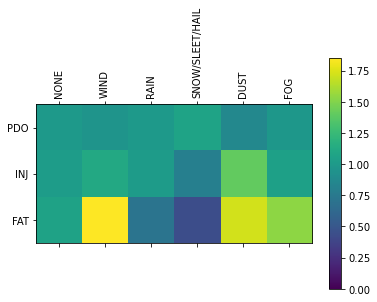

         NONE      WIND      RAIN  SNOW/SLEET/HAIL      DUST       FOG
PDO  0.993010  0.956874  0.996917         1.070885  0.861902  0.979545
INJ  1.019947  1.113736  1.015679         0.795037  1.407348  1.051041
FAT  1.067733  1.848203  0.712188         0.437504  1.724703  1.536356


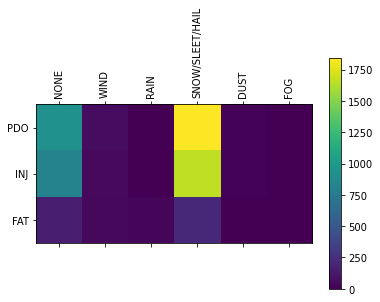

           NONE       WIND       RAIN  SNOW/SLEET/HAIL       DUST       FOG
PDO  930.761804  62.599379   1.887304      1839.146790  18.761295  5.873979
INJ  819.278837  47.069002   5.277248      1662.265912  17.646675  3.953958
FAT  155.375744  43.056724  29.246744       205.916759   0.918661  7.181317


In [42]:
newframe = pre_processing2(df.WEATHER, "WEATHER",df.SEVERITY, "SEVERITY")
lift_result = lift(newframe.WEATHER, newframe.SEVERITY, newframe)
heat_map(lift_result)
print(lift_result)

chi_result = chi_squared(newframe.WEATHER, newframe.SEVERITY, newframe)
heat_map(chi_result)
print(chi_result)


<h3>Lighting: Poor Lighting will show a correlation to fatal accidents</h3>

     DARK-LIGHTED  DARK-UNLIGHTED  DAYLIGHT  DAWN OR DUSK
INJ      1.008338        0.950264  1.006200      0.978255
PDO      0.995863        1.007836  0.999533      1.005360
FAT      1.245562        2.412901  0.736721      1.287166


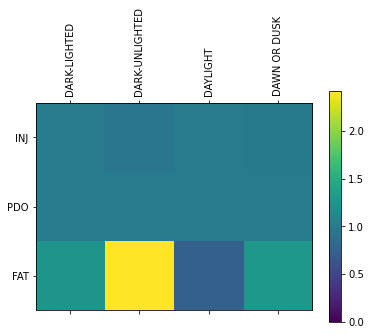

     DARK-LIGHTED  DARK-UNLIGHTED     DAYLIGHT  DAWN OR DUSK
INJ      6.084361      118.905695    41.965973     10.679232
PDO     14.112585       27.818537     2.242915      6.115894
FAT     72.460345     1317.664296  1039.153122     25.573915


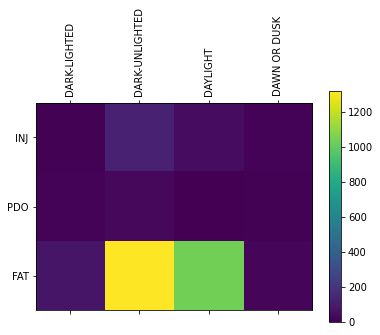

In [14]:
# lighting = pre_processing(df.LIGHTING, "LIGHTING").squeeze()
# severity = pre_processing(df.SEVERITY, "SEVERITY").squeeze()
newframe = pre_processing2(df.LIGHTING, "LIGHTING",df.SEVERITY, "SEVERITY")

lift_result = lift(newframe.LIGHTING, newframe.SEVERITY, newframe)
print(lift_result)
heat_map(lift_result)

chi_result = chi_squared(newframe.LIGHTING, newframe.SEVERITY, newframe)
print(chi_result)
heat_map(chi_result)

<h3>Road Desc: Rough road conditions show an increase in accidents</h3>

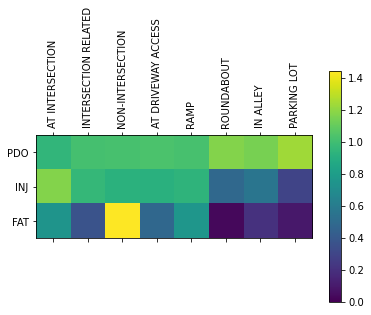

     AT INTERSECTION  INTERSECTION RELATED  NON-INTERSECTION  \
PDO         0.945197              1.017090          1.023469   
INJ         1.174225              0.958487          0.919404   
FAT         0.746229              0.369237          1.440160   

     AT DRIVEWAY ACCESS      RAMP  ROUNDABOUT  IN ALLEY  PARKING LOT  
PDO            1.031542  1.021225    1.171730  1.147085     1.233229  
INJ            0.911749  0.938704    0.485917  0.559025     0.294422  
FAT            0.480062  0.756003    0.030410  0.206611     0.092652  


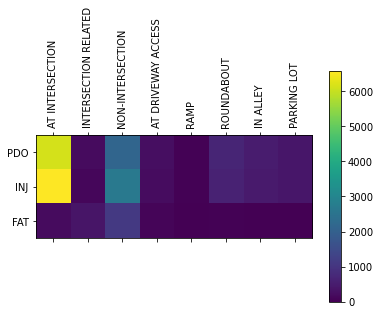

     AT INTERSECTION  INTERSECTION RELATED  NON-INTERSECTION  \
PDO      6146.042983            189.195055       2127.640233   
INJ      6561.293818            117.919635       2650.414571   
FAT       191.073676            373.685427       1085.084125   

     AT DRIVEWAY ACCESS       RAMP  ROUNDABOUT    IN ALLEY  PARKING LOT  
PDO          255.248816  40.436576  675.306730  510.476757   407.400523  
INJ          211.060186  35.623358  639.235659  484.679470   393.849734  
FAT          100.557796   7.748024   31.211963   21.535224     8.940022  


In [45]:
# road = pre_processing(df.ROAD_DESC, "ROAD_DESC").squeeze()
# cont = pre_processing(df.CONTOUR, "CONTOUR").squeeze()
newframe = pre_processing2(df.ROAD_DESC, "ROAD_DESC",df.SEVERITY, "SEVERITY")

lift_result = lift(newframe.ROAD_DESC, newframe.SEVERITY, newframe)
heat_map(lift_result)
print(lift_result)

chi_result = chi_squared(newframe.ROAD_DESC, newframe.SEVERITY, newframe)
heat_map(chi_result)
print(chi_result)

<h3>Contour: A harsher contour to the road will be correlated with higher fatalities</h3>

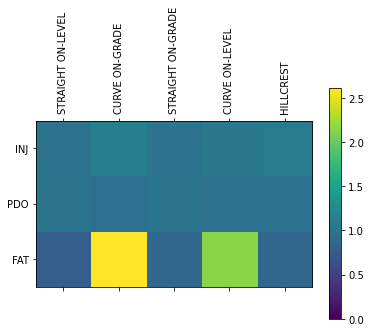

     STRAIGHT ON-LEVEL  CURVE ON-GRADE  STRAIGHT ON-GRADE  CURVE ON-LEVEL  \
INJ           0.986507        1.124256           0.991278        1.038308   
PDO           1.005589        0.950446           1.003649        0.980910   
FAT           0.789721        2.608260           0.857838        2.148839   

     HILLCREST  
INJ   1.077331  
PDO   0.975841  
FAT   0.856586  


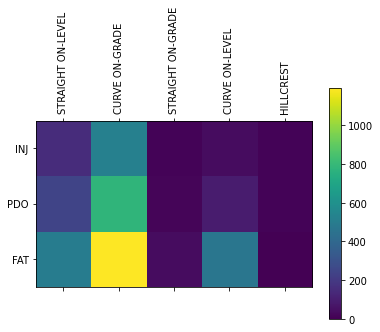

     STRAIGHT ON-LEVEL  CURVE ON-GRADE  STRAIGHT ON-GRADE  CURVE ON-LEVEL  \
INJ         150.708143      518.218429          10.897961       37.866380   
PDO         244.514567      779.349182          18.039534       88.914272   
FAT         502.496780     1191.842386          39.748267      467.535603   

     HILLCREST  
INJ  11.282428  
PDO  10.412742  
FAT   0.532729  


In [46]:
newframe = pre_processing2(df.CONTOUR, "CONTOUR",df.SEVERITY, "SEVERITY")

lift_result = lift(newframe.CONTOUR, newframe.SEVERITY, newframe)
heat_map(lift_result)
print(lift_result)

chi_result = chi_squared(newframe.CONTOUR, newframe.SEVERITY, newframe)
heat_map(chi_result)
print(chi_result)

<h3>Age: is there a correlation between age and accidents</h3>

        AGE_1 SEVERITY
0          50      PDO
1           0      PDO
2          59      INJ
3          18      PDO
4           0      PDO
...       ...      ...
112186     22      INJ
112187     19      PDO
112188     34      PDO
112189     18      PDO
112190     25      PDO

[1449091 rows x 2 columns]
['SEVERITY', 'AGE_1']


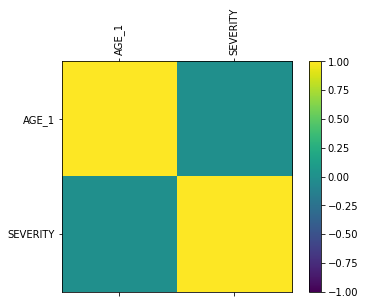

            AGE_1  SEVERITY
AGE_1     1.00000  -0.00227
SEVERITY -0.00227   1.00000


In [41]:
df_age = df[["AGE_1", "SEVERITY"]]
print(df_age)
for i in df_age.columns:
    df_age = pre_processing(df_age, i)

df_age = create_labels(df_age, ["SEVERITY", "AGE_1"])
heat_map(df_age.corr(method='pearson'), -1)
print(df_age.corr(method='pearson'))

<h3>System: type of road/speed limit will be correlated with severity of accident</h3>

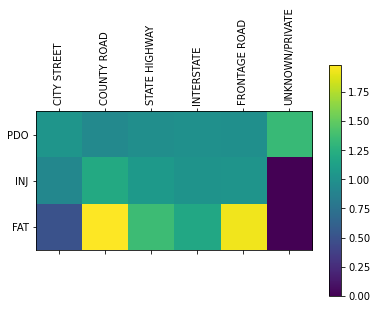

     CITY STREET  COUNTY ROAD  STATE HIGHWAY  INTERSTATE  FRONTAGE ROAD  \
PDO     1.030667     0.930636       0.977620    0.995231       0.987272   
INJ     0.914041     1.197151       1.062941    1.011480       1.022571   
FAT     0.501738     1.976198       1.351921    1.182048       1.932889   

     UNKNOWN/PRIVATE  
PDO         1.328799  
INJ         0.000000  
FAT         0.000000  


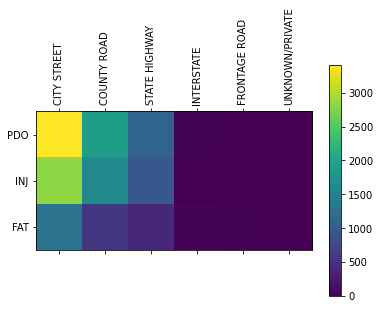

     CITY STREET  COUNTY ROAD  STATE HIGHWAY  INTERSTATE  FRONTAGE ROAD  \
PDO  3402.815211  1903.870134    1099.792536   15.049445       2.624316   
INJ  2822.644899  1623.793740     918.430212    9.207256       0.871311   
FAT  1301.408593   546.305144     393.997657   31.773800      20.425291   

     UNKNOWN/PRIVATE  
PDO         0.328799  
INJ         0.321098  
FAT         0.004406  


In [47]:
newframe = pre_processing2(df.SYSTEM, "SYSTEM",df.SEVERITY, "SEVERITY")

lift_result = lift(newframe.SYSTEM, newframe.SEVERITY, newframe)
heat_map(lift_result)
print(lift_result)

chi_result = chi_squared(newframe.SYSTEM, newframe.SEVERITY, newframe)
heat_map(chi_result)
print(chi_result)

<h3>Road Conditions: Rough road conditions show an increase in accidents</h3>

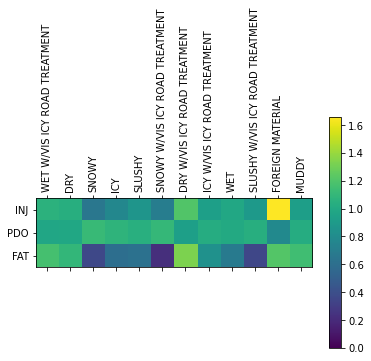

     WET W/VIS ICY ROAD TREATMENT       DRY     SNOWY       ICY    SLUSHY  \
INJ                      1.063422  1.035875  0.653958  0.764940  0.863552   
PDO                      0.978506  0.987840  1.115741  1.078423  1.046405   
FAT                      1.166091  1.094181  0.355972  0.596320  0.614876   

     SNOWY W/VIS ICY ROAD TREATMENT  DRY W/VIS ICY ROAD TREATMENT  \
INJ                        0.702731                      1.202236   
PDO                        1.100729                      0.932656   
FAT                        0.224430                      1.325348   

     ICY W/VIS ICY ROAD TREATMENT       WET  SLUSHY W/VIS ICY ROAD TREATMENT  \
INJ                      0.936846  0.992847                         0.887453   
PDO                      1.021405  1.004183                         1.040202   
FAT                      0.834245  0.680618                         0.353160   

     FOREIGN MATERIAL     MUDDY  
INJ          1.654341  0.927131  
PDO          0.787025  1.

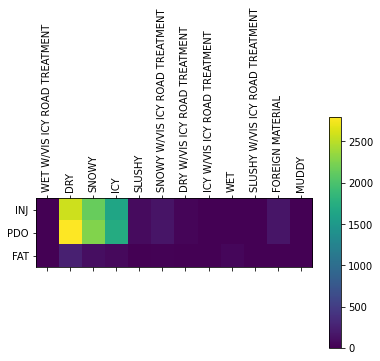

     WET W/VIS ICY ROAD TREATMENT          DRY        SNOWY          ICY  \
INJ                      2.272417  2573.522577  2145.613465  1635.845432   
PDO                      2.462743  2789.685539  2264.890858  1718.110550   
FAT                      0.214116   243.677080   102.104744    66.283000   

        SLUSHY  SNOWY W/VIS ICY ROAD TREATMENT  DRY W/VIS ICY ROAD TREATMENT  \
INJ  78.181231                      144.440344                     38.431608   
PDO  85.326014                      156.484636                     40.210727   
FAT   8.556756                       13.507417                      1.366502   

     ICY W/VIS ICY ROAD TREATMENT        WET  SLUSHY W/VIS ICY ROAD TREATMENT  \
INJ                      5.961047   1.771627                         5.249120   
PDO                      6.461602   5.716950                         6.319743   
FAT                      0.564155  48.530906                         2.382078   

     FOREIGN MATERIAL     MUDDY  
INJ        155.

In [48]:
newframe = pre_processing2(df.CONDITION, "CONDITION",df.SEVERITY, "SEVERITY")

lift_result = lift(newframe.CONDITION, newframe.SEVERITY, newframe)
heat_map(lift_result)
print(lift_result)

chi_result = chi_squared(newframe.CONDITION, newframe.SEVERITY, newframe)
heat_map(chi_result)
print(chi_result)

<h3>City: Does the city your in have a correlation with likelyhood of accident</h3>

In [19]:
# lift(df.CITY, df.SEVERITY)
# chi_squared(df.CITY, df.SEVERITY)

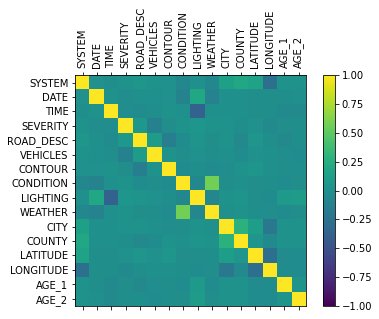

C:\Users\devin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:5218: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


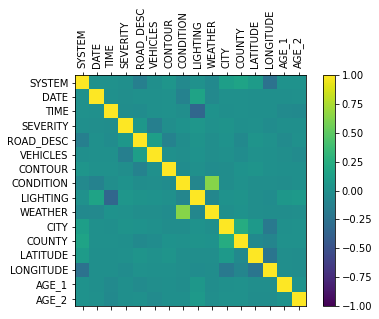

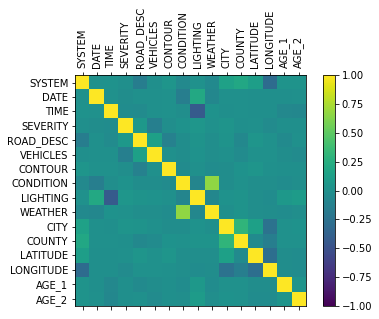

In [22]:
columns = ['SYSTEM', 'DATE', 'TIME', 'SEVERITY', 'ROAD_DESC', 'VEHICLES', 'CONTOUR', 'CONDITION', 'LIGHTING', 
             'WEATHER', 'CITY', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'AGE_1', 'AGE_2']
df_all = df[columns]
for i in columns:
    df_all = pre_processing(df_all, i)

df_all = create_labels(df_all, columns)
heat_map(df_all.corr(method='pearson'), -1)
heat_map(df_all.corr(method='kendall'), -1)
heat_map(df_all.corr(method='spearman'), -1)


